In [1]:

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import pandas as pd

from scipy.special import logsumexp
from scipy.special import softmax
from scipy.stats import invwishart
from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans

from sklearn import metrics
import scipy.sparse as sparse

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score

import seaborn as sns
from sklearn.metrics import mean_squared_error


from datasets.Dataset import Dataset

import random

from models.PriorParameters import GMMPriorParameters
from models.PriorParameters import BMMPriorParameters
from models.GMMGibbs import GMMGibbs
from models.BMMGibbs import BMMGibbs
from models.GMMVBEM import GMMVBEM
from models.BMMVBEM import BMMVBEM
from models.BMMEM import BMMEM
from models.GMMEM import GMMEM

from utils.EvaluationUtilities import multi_restart, rmse
from utils.ArbitraryImputer import mean_impute, median_impute, mode_impute

In [19]:
X_train = np.load("./../Datasets/Gaussian/Processed/synthetic/X_train_synthetic.npy")
y_train = np.load("./../Datasets/Gaussian/Processed/synthetic/y_train_synthetic.npy")

In [68]:
X_train = np.load("./../Datasets/Gaussian/Processed/penguin/X_train_penguin.npy")
y_train = np.load("./../Datasets/Gaussian/Processed/penguin/y_train_penguin.npy")

In [2]:
dirpath = "./../Datasets/Gaussian/Processed/iris/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

In [22]:
dirpath_digits = "./../Datasets/Gaussian/Processed/digits/"
X_train_digits = np.load(dirpath_digits + "X_train_digits.npy")
y_train_digits = np.load(dirpath_digits + "y_train_digits.npy")
X_test_digits = np.load(dirpath_digits + "X_test_digits.npy")
y_test_digits = np.load(dirpath_digits + "y_test_digits.npy")

digits_mean = np.load(dirpath_digits + "means_digits.npy")
digits_cov = np.load(dirpath_digits + "covariances_digits.npy")

In [24]:
%%time
params = GMMPriorParameters(X_train_digits, 10)
gmm_model = GMMGibbs(params)
samples = gmm_model.fit(X_train_digits, num_iters=1000, burn=250)
obj = gmm_model.get_summarizing_results(y_train_digits)
print(obj)

{'avg_ari': 0.6716344377386307, 'avg_ll': np.float64(13.125055657231377), 'avg_pl': np.float64(73399.90033846803)}
CPU times: user 2h 32min 23s, sys: 2.24 s, total: 2h 32min 25s
Wall time: 19min 54s


In [25]:
def paint_mnist(X):
    figure = plt.figure(figsize=(7, 3.5))
    rows, cols= 2, 5
    for k in range(10):
        img = X[k,:].reshape(7,5)
        figure.add_subplot(rows, cols, k+1)
        plt.imshow(img, cmap="gray")
    plt.show()

In [26]:
aligned_params = gmm_model.get_aligned_param_means()

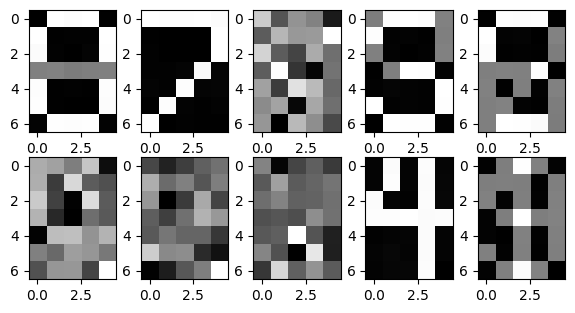

In [29]:
paint_mnist(samples['μ'])

In [3]:
%%time
params = GMMPriorParameters(X_train, 5)
gmm_model = GMMGibbs(params)
samples = gmm_model.fit(X_train, num_iters=1000, burn=250)
obj = gmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': 0.7819253438113948, 'avg_ll': np.float64(-12.991206757141677), 'avg_pl': np.float64(-13367.208090694514)}
CPU times: user 1min 29s, sys: 89.9 ms, total: 1min 30s
Wall time: 1min 30s


In [64]:
dataset = Dataset(X_train, y_train)

In [65]:
X_cover1,M = dataset.apply_missingness(0.5)

In [66]:
mask = np.isnan(X_cover1)
np.sum(mask)/480

np.float64(0.47291666666666665)

In [67]:
%%time
params = GMMPriorParameters(X_cover1, 3)
gmm_model = GMMGibbs(params)
samples = gmm_model.fit(X_cover1, num_iters=1000, burn=500)
obj = gmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': 0.46990944224500525, 'avg_ll': np.float64(-2.7968358930333705), 'avg_pl': np.float64(-359.2429179723696)}
CPU times: user 31.1 s, sys: 34.4 ms, total: 31.2 s
Wall time: 31.3 s


In [13]:
map_obj = gmm_model.get_map_params()
print(adjusted_rand_score(map_obj['z'], y_train))
aligned_obj = gmm_model.get_aligned_param_means()
print(adjusted_rand_score(aligned_obj['z'], y_train))

0.5672727272727273
0.5672727272727273


In [10]:
X_fitted = gmm_model.posterior_predict(X_cover1)
print(X_train[0])
print(X_cover1[0])
print(X_fitted[0])

[-1.72156775 -0.32483982 -1.34703555 -1.32016847]
[       nan -0.3248398        nan -1.3201685]
[-1.2208216  -0.3248398  -0.19283114 -1.3201685 ]


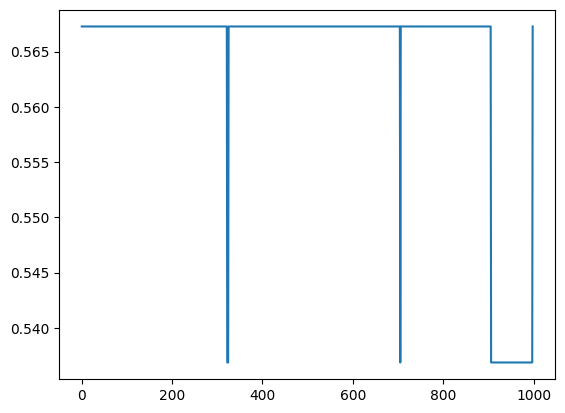

In [11]:
scores = [adjusted_rand_score(s['z'],y_train) for s in samples]
plt.plot(scores)

---

In [10]:
dirpath = "./../Datasets/Bernoulli/Processed/MP2024/"
X_train = np.load(dirpath + "X_mp2024.npy")
y_train = np.load(dirpath + "y_mp2024.npy")

In [16]:
dirpath = "./../Datasets/Bernoulli/Processed/mushroom/"

X_train = np.load(dirpath + "X_train_mushroom.npy")
y_train = np.load(dirpath + "y_train_mushroom.npy")

In [2]:
dirpath = "./../Datasets/Bernoulli/Processed/synthetic/"

X_train = np.load(dirpath + "X_train_synthetic.npy")
y_train = np.load(dirpath + "y_train_synthetic.npy")

bmm_synthetic_dataset = Dataset(X_train, y_train)

In [3]:
X_cover1 = bmm_synthetic_dataset.apply_missingness(1)[0]

In [4]:
%%time
params = BMMPriorParameters(X_cover1, 5)
bmm_model = BMMGibbs(params)
samples = bmm_model.fit(X_cover1, num_iters=1000, burn=250)
obj = bmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': -1.3870330312532129e-05, 'avg_ll': np.float64(-4.814063850453029e-18), 'avg_pl': np.float64(-1081.694489897963)}
CPU times: user 21.1 s, sys: 33 ms, total: 21.1 s
Wall time: 21.1 s


In [8]:
%%time
params = BMMPriorParameters(X_cover1, 5)
bmm_model = BMMEM(5)
samples = bmm_model.fit(X_cover1, tol=1e-3)
print(adjusted_rand_score(samples['z'], y_train))

0.0
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 232 ms


In [11]:
%%time
params = BMMPriorParameters(X_train, 9)
bmm_model = BMMGibbs(params)
samples = bmm_model.fit(X_train, num_iters=1000, burn=250)
obj = bmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': 0.9359237749735886, 'avg_ll': np.float64(-5.315642749167114), 'avg_pl': np.float64(-3377.662893684977)}
CPU times: user 1min 51s, sys: 42.6 ms, total: 1min 51s
Wall time: 29 s


---

In [12]:
def generate_mnar_pattern(X,y,K):
    N,D = X.shape

    obs_mask = np.array([
        [0,1,1,1,1,1,1,1,1,0],
        [1,0,1,1,1,1,1,1,0,1],
        [1,1,0,1,1,1,1,0,1,1],
        [1,1,1,0,1,1,0,1,1,1],
        [1,1,1,0,1,0,1,1,1,1],
        [1,1,1,1,0,0,1,1,1,1],
        [1,1,1,0,1,1,0,1,1,1],
        [1,1,0,1,1,1,1,0,1,1],
        [1,0,1,1,1,1,1,1,0,1],
        [0,1,1,1,1,1,1,1,1,0]
    ])

    X_missing = X.copy().astype(np.float64).copy()

    for n in range(N):
        k = y[n]
        X_missing[n][~obs_mask[k]] = np.nan

    return X_missing

In [13]:
dirpath_synthetic = "./../Datasets/Bernoulli/Processed/synthetic/"

X_train_synthetic = np.load(dirpath_synthetic + "X_train_synthetic.npy")
y_train_synthetic = np.load(dirpath_synthetic + "y_train_synthetic.npy")
X_test_synthetic = np.load(dirpath_synthetic + "X_test_synthetic.npy")
y_test_synthetic = np.load(dirpath_synthetic + "y_test_synthetic.npy")
means = np.load(dirpath_synthetic + "means_synthetic.npy")

In [14]:
X_cover1 = generate_mnar_pattern(X_train_synthetic, y_train_synthetic, 10)

In [17]:
%%time
params = BMMPriorParameters(X_cover1, 10)
bmm_model = BMMGibbs(params)
samples = bmm_model.fit(X_cover1, num_iters=2000, burn=500)
# obj = bmm_model.get_summarizing_results(y_train)
print(adjusted_rand_score(samples['z'], y_train_synthetic))

0.6250838902827117
CPU times: user 3min 22s, sys: 137 ms, total: 3min 22s
Wall time: 3min 23s


In [18]:
%%time
params = BMMPriorParameters(X_cover1, 10)
bmm_model = BMMGibbs(params)
samples = bmm_model.fit(X_cover1, num_iters=2000, burn=500, mnar=True)
# obj = bmm_model.get_summarizing_results(y_train)
print(adjusted_rand_score(samples['z'], y_train_synthetic))

0.5937773514337324
CPU times: user 10min 16s, sys: 167 ms, total: 10min 16s
Wall time: 3min 30s


In [9]:
bmm_model.posterior_predict(X_train_synthetic)

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 0, 0, 0]])

In [2]:
dirpath = "./../Datasets/Bernoulli/Processed/MP2024/"
X = np.load(dirpath + "X_mp2024.npy")
y = np.load(dirpath + "y_mp2024.npy")

In [4]:
%%time
params = BMMPriorParameters(X, 9)
bmm_model = BMMGibbs(params)
samples = bmm_model.fit(X, num_iters=500, burn=150)
obj = bmm_model.get_summarizing_results(y)
print(obj)

{'avg_ari': 0.927724260898455, 'avg_ll': np.float64(-5.499253649819568), 'avg_pl': np.float64(-3495.9166015187)}
CPU times: user 51.1 s, sys: 1.8 s, total: 52.9 s
Wall time: 13.7 s


In [5]:
print(adjusted_rand_score(samples['z'], y))

0.9414519521974933


In [6]:
bmm_model.posterior_predict(X)

{'θ': array([[0.50205831, 0.47822376, 0.51710622, ..., 0.47753663, 0.51399082,
        0.50679862],
       [0.50422594, 0.51307167, 0.50179243, ..., 0.49268637, 0.5002915 ,
        0.4944069 ],
       [0.48545442, 0.51453001, 0.49097328, ..., 0.50266845, 0.48275307,
        0.49952089],
       ...,
       [0.50962171, 0.53216989, 0.49053459, ..., 0.51983557, 0.4972905 ,
        0.48646584],
       [0.97923012, 0.00399953, 0.00364363, ..., 0.0026796 , 0.00243466,
        0.53868332],
       [0.51865386, 0.4899109 , 0.49454196, ..., 0.49226006, 0.49423049,
        0.53173612]]), 'π': array([1.25207001e-04, 1.70812832e-04, 9.77989968e-05, 2.03999665e-01,
       1.02941342e-04, 1.10897249e-04, 1.69367691e-03, 1.19309289e-04,
       1.50149418e-01, 1.22410390e-04, 8.05194889e-05, 6.43062156e-01,
       1.65187483e-04]), 'z': array([11, 11, 11, 11, 11, 11, 11, 11, 11,  8, 11,  3, 11, 11, 11,  3, 11,
        3, 11,  8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  3,
       11, 11,  8,

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

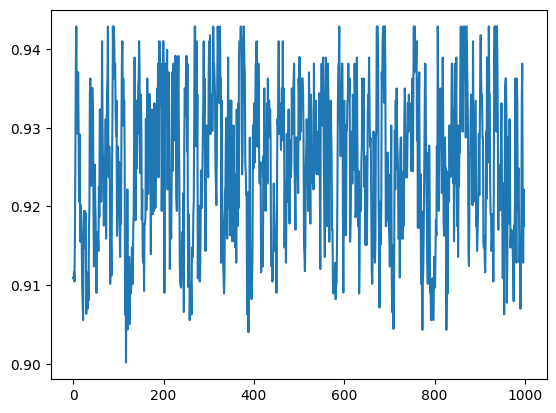

In [5]:
scores = [adjusted_rand_score(sample['z'],y) for sample in samples]
plt.plot(scores)

---
---

# VBEM

In [13]:
def multi_restart(model, X, y, N=10, max_iters=200, tol=1e-3):
    samples = []
    scores1 = []
    scores2 = []
    scores3 = []

    for n in range(N):
        sample = model.fit(X, max_iters, tol)
        samples.append(sample)
        scores1.append(adjusted_rand_score(y,sample['z']))
        scores2.append(sample['elbo'][-1])
        scores3.append(sample['loglike'][-2])

    return scores1, scores2, scores3

In [14]:
dirpath = "./../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [ ]:
plt.plot(scores1)
plt.show()
plt.plot(scores2)
plt.show()
plt.plot(scores3)
plt.show()

In [18]:
params = GMMPriorParameters(X_cover1, 3)
gmm_vbem_model = GMMVBEM(params)
scores1, scores2, scores3 = multi_restart(gmm_vbem_model, X_cover1, y_train)

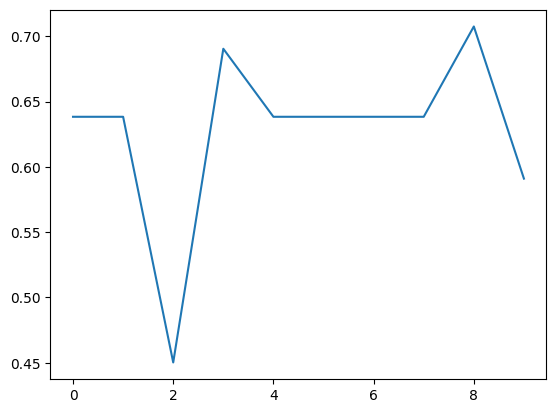

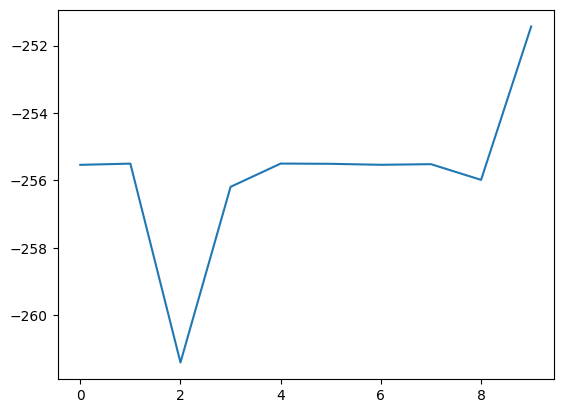

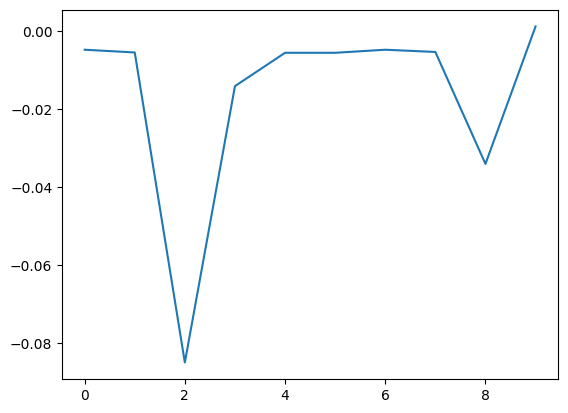

In [19]:
plt.plot(scores1)
plt.show()
plt.plot(scores2)
plt.show()
plt.plot(scores3)
plt.show()

In [5]:
params = GMMPriorParameters(X_train, 3)
gmm_vbem_model = GMMVBEM(params)
result = multi_restart(gmm_vbem_model, X_train,y_train,10)

In [33]:
dirpath_digits = "./../Datasets/Gaussian/Processed/digits5x5/"
X_train_digits = np.load(dirpath_digits + "X_train_digits5x5.npy")
y_train_digits = np.load(dirpath_digits + "y_train_digits5x5.npy")
X_test_digits = np.load(dirpath_digits + "X_test_digits5x5.npy")
y_test_digits = np.load(dirpath_digits + "y_test_digits5x5.npy")

digits_mean = np.load(dirpath_digits + "means_digits5x5.npy")
digits_cov = np.load(dirpath_digits + "covariances_digits5x5.npy")

In [34]:
params = GMMPriorParameters(X_train_digits, 10)
gmm_vbem_model = GMMVBEM(params)
result = gmm_vbem_model.fit(X_train_digits, tol=1e-3)
adjusted_rand_score(y_train_digits,result['z'])

0.8695670694602498

In [3]:
params = GMMPriorParameters(X_train, 3)
gmm_vbem_model = GMMVBEM(params)
result = gmm_vbem_model.fit(X_train, tol=1e-3)
adjusted_rand_score(y_train,result['z'])

0.5020708856589507

In [ ]:
params = GMMPriorParameters(X_cover1, 3)
gmm_vbem_model = GMMVBEM(params) 
result = gmm_vbem_model.fit(X_cover1, tol=1e-3)
adjusted_rand_score(y_train,result['z'])

0.5952220735662395

In [8]:
X_filled = gmm_vbem_model.posterior_predict(X_cover1)
print(X_train[0])
print(X_cover1[0])
print(X_filled[0])

[-1.72156775 -0.32483982 -1.34703555 -1.32016847]
[-1.7215677        nan        nan -1.3201685]
[-1.7215677   0.13849312 -1.3250586  -1.3201685 ]


In [12]:
dirpath_synthetic = "./../Datasets/Bernoulli/Processed/synthetic/"

X_train_synthetic = np.load(dirpath_synthetic + "X_train_synthetic.npy")
y_train_synthetic = np.load(dirpath_synthetic + "y_train_synthetic.npy")
X_test_synthetic = np.load(dirpath_synthetic + "X_test_synthetic.npy")
y_test_synthetic = np.load(dirpath_synthetic + "y_test_synthetic.npy")
means = np.load(dirpath_synthetic + "means_synthetic.npy")

bmm_synthetic_dataset = Dataset(X_train_synthetic, y_train_synthetic)

In [14]:
X_cover1,_ = bmm_synthetic_dataset.apply_missingness(0.2)

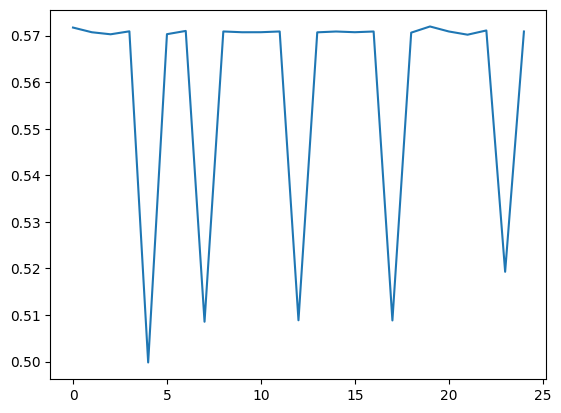

In [15]:
synthetic_params = BMMPriorParameters(X_cover1, 10)
vbem_gmm_model = BMMVBEM(synthetic_params)
scores = []
iters = []
samples=[]
for i in range(25):
    result = vbem_gmm_model.fit(X_cover1)
    samples.append(result)
    scores.append(adjusted_rand_score(result['z'], y_train_synthetic))
    iters.append(len(result['loglike']))

plt.plot(scores)
plt.show()

In [16]:
dirpath = "./../Datasets/Bernoulli/Processed/mushroom/"

X_train = np.load(dirpath + "X_train_mushroom.npy")
y_train = np.load(dirpath + "y_train_mushroom.npy")
mushroom_dataset = Dataset(X_train, y_train)
X_cover1 = mushroom_dataset.apply_missingness(0.1)[0]
X_cover2 = mushroom_dataset.apply_missingness(0.2)[0]

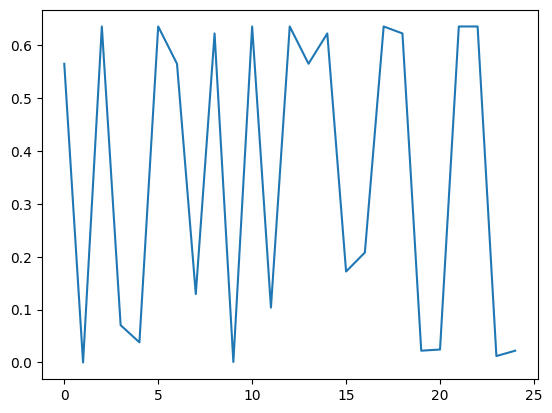

In [17]:
synthetic_params = BMMPriorParameters(X_cover1, 2)
vbem_gmm_model = BMMVBEM(synthetic_params)
scores = []
iters = []
samples=[]
for i in range(25):
    result = vbem_gmm_model.fit(X_cover1)
    samples.append(result)
    scores.append(adjusted_rand_score(result['z'], y_train))
    iters.append(len(result['loglike']))

plt.plot(scores)
plt.show()

In [22]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]
X_mnist_cover1 = np.empty_like(X_mnist_train, dtype='f')
X_mnist_cover1[:] = X_mnist_train
for i in range(0,len(X_mnist_cover1)):
    indices = random.sample(range(0,784), 784//2)
    X_mnist_cover1[i][indices] = np.nan

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=225)
X_mnist_reduced = pca.fit_transform(X_mnist_train)

0.37635089598621113
CPU times: user 7min 48s, sys: 14.9 s, total: 8min 3s
Wall time: 3min 14s


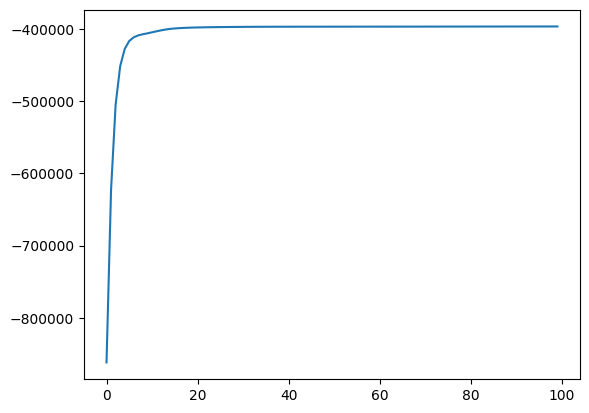

In [4]:
%%time
params = BMMPriorParameters(X_mnist_cover1, 10)
bmm_vbem_model = BMMVBEM(params)
result = bmm_vbem_model.fit(X_mnist_cover1, tol=1e-3)
print(adjusted_rand_score(Y_mnist_train,result['z']))
plt.plot(result['elbos'])

In [7]:
def paint_mnist(X):
    figure = plt.figure(figsize=(7, 3.5))
    rows, cols= 2, 5
    for k in range(10):
        img = X[k, :].reshape(28, 28)
        figure.add_subplot(rows, cols, k+1)
        plt.title(k)
        plt.axis("off")
        plt.imshow(img, cmap="gray")
    plt.show()

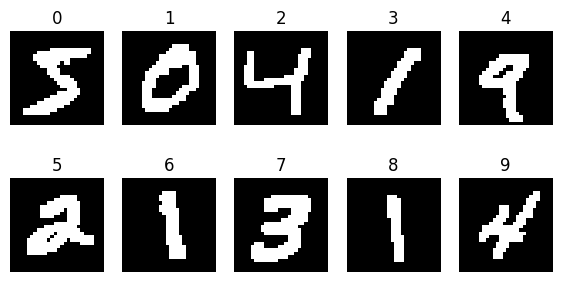

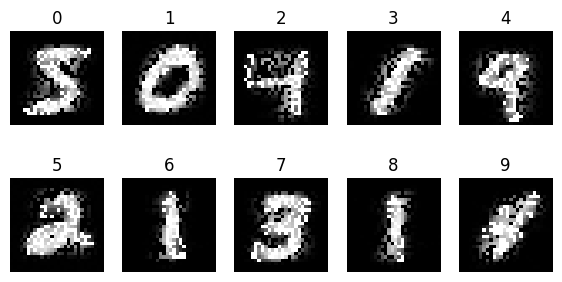

In [8]:
X_filled = bmm_vbem_model.posterior_predict(X_mnist_cover1)
paint_mnist(X_mnist_train)
paint_mnist(X_filled)

---

# EM 

### EM BMM

In [10]:
name="shapes"
X_train= np.load(f"./../Datasets/Bernoulli/Processed/{name}/X_train_{name}.npy")
X_test=np.load(f"./../Datasets/Bernoulli/Processed/{name}/X_test_{name}.npy")
y_train=np.load(f"./../Datasets/Bernoulli/Processed/{name}/y_train_{name}.npy")
y_test=np.load(f"./../Datasets/Bernoulli/Processed/{name}/y_test_{name}.npy")

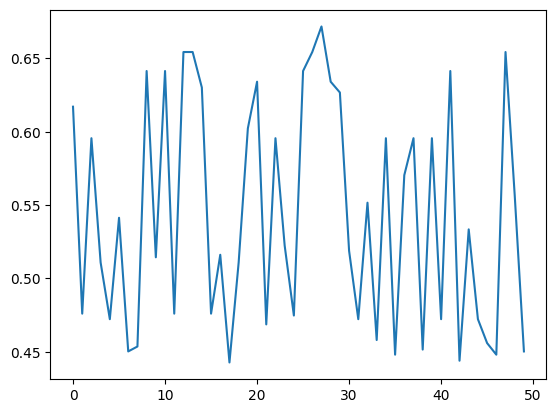

In [11]:
em_bmm_model = BMMEM(3)
scores = []
iters = []
samples=[]
for i in range(50):
    result = em_bmm_model.fit(X_train)
    samples.append(result)
    scores.append(adjusted_rand_score(result['z'], y_train))
    iters.append(len(result['loglike']))

plt.plot(scores)
plt.show()

In [18]:
dirpath = "./../Datasets/Bernoulli/Processed/mushroom/"

X_train = np.load(dirpath + "X_train_mushroom.npy")
y_train = np.load(dirpath + "y_train_mushroom.npy")

N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [2]:
from datasets.Dataset import Dataset
dirpath_synthetic = "./../Datasets/Bernoulli/Processed/synthetic/"

X_train = np.load(dirpath_synthetic + "X_train_synthetic.npy")
y_train = np.load(dirpath_synthetic + "y_train_synthetic.npy")
X_test = np.load(dirpath_synthetic + "X_test_synthetic.npy")
y_test = np.load(dirpath_synthetic + "y_test_synthetic.npy")
N,D = X_train.shape
dataset = Dataset(X_train, y_train)
X_cover1 = dataset.apply_missingness(0.2)

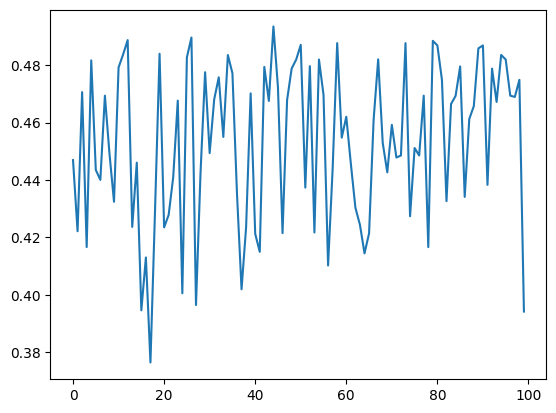

In [3]:
em_bmm_model = BMMEM(5)
scores = []
iters = []
samples=[]
for i in range(100):
    result = em_bmm_model.fit(X_train)
    samples.append(result)
    scores.append(adjusted_rand_score(result['z'], y_train))
    iters.append(len(result['loglike']))

plt.plot(scores)
plt.show()

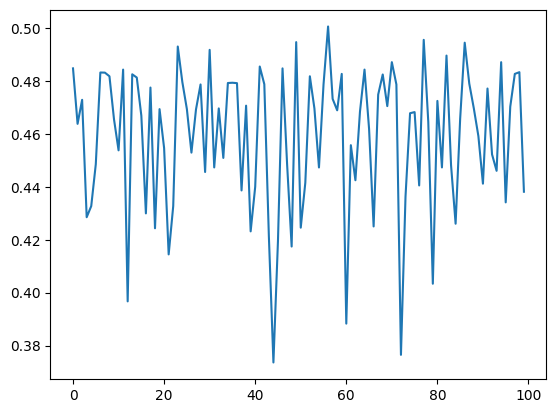

In [31]:
em_bmm_model = BMMEM(5)
scores = []
iters = []
samples=[]
for i in range(100):
    result = em_bmm_model.fit(X_train)
    samples.append(result)
    scores.append(adjusted_rand_score(result['z'], y_train))
    iters.append(len(result['loglike']))

plt.plot(scores)
plt.show()

In [ ]:
em_bmm_model = BMMEM(10)
scores = []
iters = []
samples=[]
for i in range(100):
    result = em_bmm_model.fit(X_train)
    samples.append(result)
    scores.append(adjusted_rand_score(result['z'], y_train))
    iters.append(len(result['loglike']))

plt.plot(scores)
plt.show()

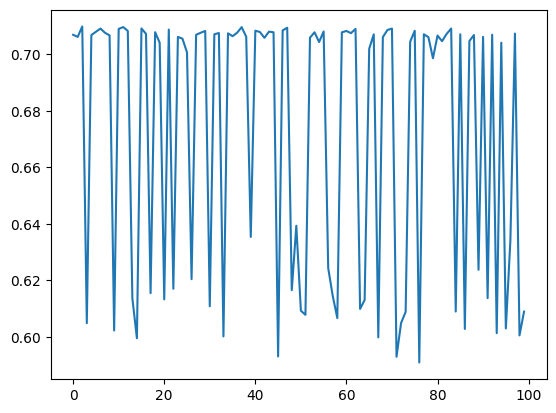

In [3]:
em_bmm_model = BMMEM(10)
scores = []
iters = []
samples=[]
for i in range(100):
    result = em_bmm_model.fit(X_train)
    samples.append(result)
    scores.append(adjusted_rand_score(result['z'], y_train))
    iters.append(len(result['loglike']))

plt.plot(scores)
plt.show()

### EM GMM

In [5]:
def trace(model, X, y):
    scores = []
    iters = []
    samples=[]
    for i in range(20):
        print(i)
        result = model.fit(X, tol=1e-3)
        samples.append(result)
        scores.append(adjusted_rand_score(result['z'], y))
        iters.append(len(result['loglike']))

    plt.plot(scores)
    plt.show()

In [3]:
dirpath = "./../Datasets/Gaussian/Processed/synthetic/"
X_train = np.load(dirpath + "X_train_synthetic.npy")
y_train = np.load(dirpath + "y_train_synthetic.npy")

synthetic_dataset = Dataset(X_train, y_train)
X_cover1 = synthetic_dataset.apply_missingness(0.2)[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


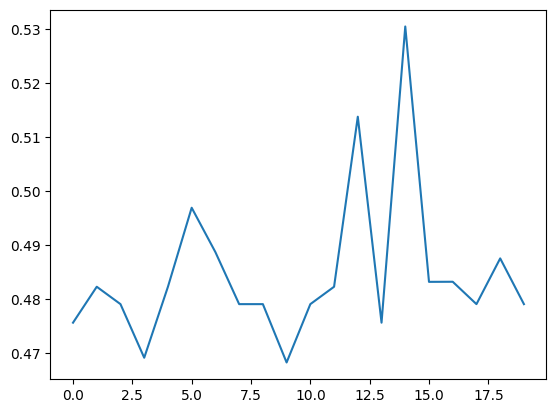

In [9]:
synthetic_params = GMMPriorParameters(X_train,3)
trace(GMMEM(3), X_cover1,y_train)

In [6]:
dirpath = "./../Datasets/Gaussian/Processed/iris/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

iris_dataset = Dataset(X_train, y_train)

In [7]:
X_cover1,_ = iris_dataset.apply_missingness(0.3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


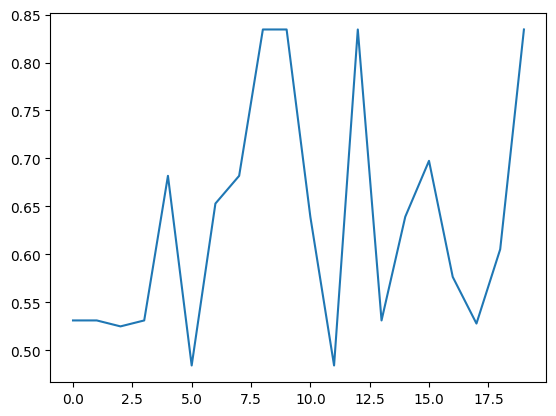

In [8]:
iris_params = GMMPriorParameters(X_train,3)
trace(GMMVBEM(iris_params), X_cover1,y_train)

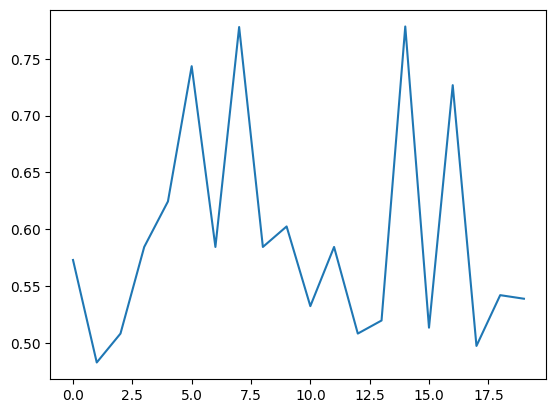

In [6]:
trace(GMMEM(3), X_cover1,y_train)

In [7]:
loglikes = [r['loglike'][-1] for r in samples]
best_idx = np.argmax(loglikes)
print(adjusted_rand_score(y_train, samples[best_idx]['z']))

0.90354507060279


In [6]:
em_gmm_model = GMMEM(3)
result = em_gmm_model.fit(X_cover1)
print(adjusted_rand_score(result['z'], y_train))

0.558610538710627
